In [69]:
import pandas as pd
import xgboost as xgb
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve

In [70]:
df_ohe_var = pd.read_csv('C:\\Users\\jk\Desktop\\data science - infoshare\\projekt_SQL\\jdszr4-edc\\3-projekt-ml\\knn\\one_hot_encoded_var.csv')

df_ohe_corr = pd.read_csv('C:\\Users\\jk\\Desktop\\data science - infoshare\\projekt_SQL\\jdszr4-edc\\3-projekt-ml\\knn\\one_hot_encoded_corr.csv')


# Model dla danych przygotowanych z zastosowaniem one hot encodingu i wybranych na podstawie variance treshold

In [96]:
# train - test split
X_train, X_test, y_train, y_test = train_test_split(
    df_ohe_var.drop(['class_e', 'class_p'], axis=1),
    df_ohe_var['class_p'],
    test_size=0.25,
    random_state=40)

print(X_test.shape)
print(X_train.shape)

#alignment kolumn
X_train.sort_index(axis=1, inplace=True)
X_test.sort_index(axis=1,inplace=True)

(2031, 107)
(6093, 107)


In [97]:
# model
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

C:\Users\jk\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:45:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [98]:
#Accuracy

print(f'Accuracy of the xgb model euqals {accuracy_score(y_test, y_pred)}')

Accuracy of the xgb model euqals 1.0


In [99]:
# Raport modelu

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1056
           1       1.00      1.00      1.00       975

    accuracy                           1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031



Text(0, 0.5, 'True positive rate')

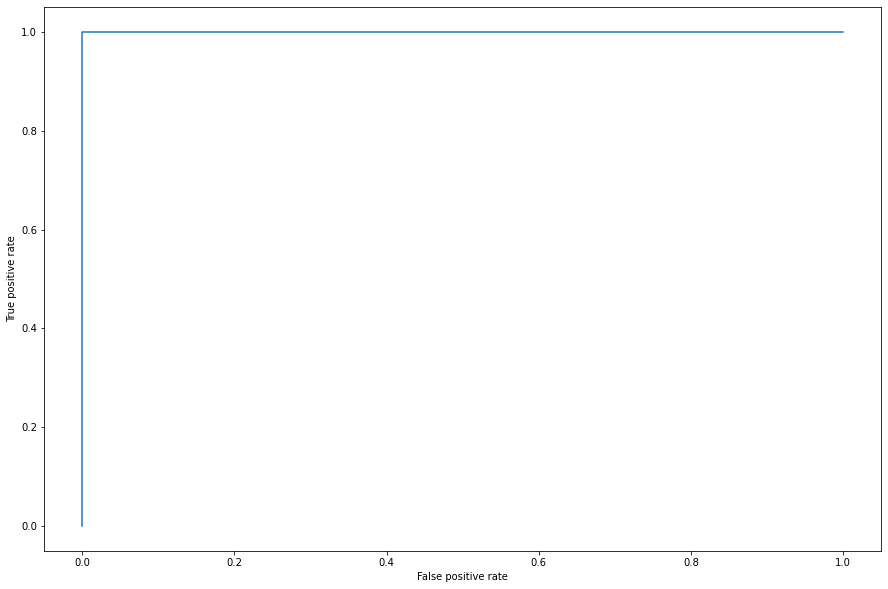

In [100]:
# Receiver operating characteristic
probas = model.predict_proba(X_test)
positive_proba = probas[:, 1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, positive_proba)
plt.figure(figsize=(15, 10))
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

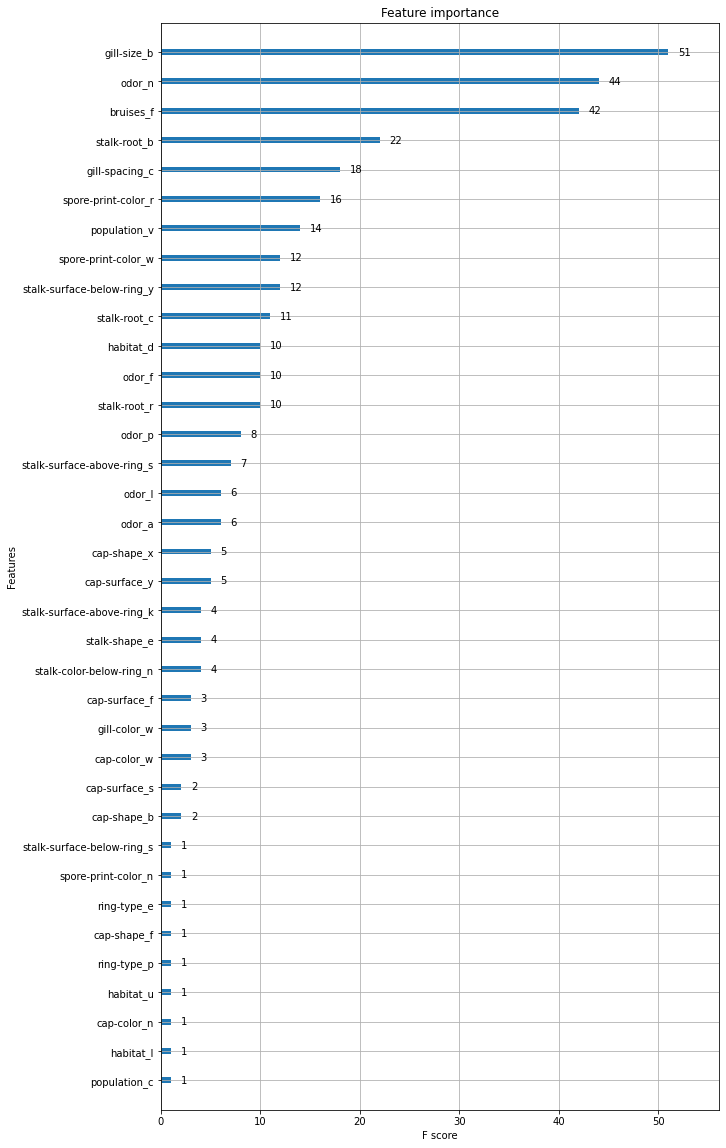

In [101]:
#Feature importance 
fig, ax = plt.subplots(figsize=(10, 20))
xgb.plot_importance(model, ax=ax)

# Test modelu

In [102]:
def shroom_check(sample, prediction: int, df):
    """
    Function checks if prediction was consistent with the class value from original dataframe.
    """
    
    ix = sample.index[0]
    row_ix = df[df.columns[2:]].iloc[ix:ix+1]
    result = prediction == df.iloc[ix]['class_p']

    return result

In [103]:
s_test = X_test.sample()
s_test

,bruises_f,bruises_t,cap-color_b,cap-color_c,cap-color_e,cap-color_g,cap-color_n,cap-color_p,cap-color_r,cap-color_u,...,stalk-shape_e,stalk-shape_t,stalk-surface-above-ring_f,stalk-surface-above-ring_k,stalk-surface-above-ring_s,stalk-surface-above-ring_y,stalk-surface-below-ring_f,stalk-surface-below-ring_k,stalk-surface-below-ring_s,stalk-surface-below-ring_y
6697,1,0,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,1,0,0


In [104]:
s_test.index[:]

Int64Index([6697], dtype='int64')

In [105]:
prediction = int(model.predict(s_test))
prediction

1

In [106]:
shroom_check(s_test, prediction, df_ohe_var)

True

In [107]:
def test_prediction(n: int, df, model):
    """
    Function gives results for n iteration of prediction from random samples from dataset.
    """
    
    correct_values = 0
    i = 0
    X = df.copy(deep=False)
    
    for col in X.columns:
        if 'class' in col:
            X.drop(col, axis=1, inplace=True)
    
    while i < n:
        sample = X.sample()
        prediction = int(model.predict(sample))
        check = shroom_check(sample, prediction, df)
    
        if check == True:
            correct_values += 1
        
        i += 1

    print(f'True predictions: {correct_values} ({100 * correct_values / n}%)')
    print(f'False predictions: {n - correct_values} ({100 - 100 * correct_values / n}%)')

In [108]:
test_prediction(100, df_ohe_var, model)

True predictions: 58 (58.0%)
False predictions: 42 (42.0%)


In [109]:
def get_features(df):
    columns_original = set()
    
    for column in df.columns:
        if column[:-2] in ['class']:
            continue
        columns_original.add(column[:-2])
    
    return list(columns_original)

In [110]:
def get_random_features(df, n_randoms: int):
    
    columns_original = get_features(df)
    
    random_columns = set()
    
    for i in range(n_randoms):
        random_column = columns_original[np.random.randint(0, len(columns_original))]
        random_columns.add(random_column)
        columns_original.remove(random_column)
    
    return random_columns

In [111]:
def copy_df_with_nan_values(df, columns_to_nan = set(), filler = -1):
    """
    Function returns a copy from dataset with n features filled with filler.
    The filler value is set to default as -1.
    """
    
    df_copy = df.copy()
    
    for column in df_copy.columns:
        if column[:-2] in columns_to_nan:
            df_copy[column] = np.NaN
     
    df_copy.fillna(filler, inplace=True)
    
    return df_copy

In [112]:
for col in get_features(df_ohe_var):
    print(f'Results for {col}')
    g = copy_df_with_nan_values(df_ohe_var, set([col]))
    test_prediction(1000, g, model)
    print('\n')

Results for habitat
True predictions: 516 (51.6%)
False predictions: 484 (48.4%)


Results for gill-spacing
True predictions: 557 (55.7%)
False predictions: 443 (44.3%)


Results for bruises
True predictions: 590 (59.0%)
False predictions: 410 (41.0%)


Results for stalk-shape
True predictions: 404 (40.4%)
False predictions: 596 (59.6%)


Results for stalk-root
True predictions: 554 (55.4%)
False predictions: 446 (44.6%)


Results for stalk-color-below-ring
True predictions: 559 (55.9%)
False predictions: 441 (44.1%)


Results for population
True predictions: 564 (56.4%)
False predictions: 436 (43.6%)


Results for cap-surface
True predictions: 568 (56.8%)
False predictions: 432 (43.2%)


Results for ring-type
True predictions: 533 (53.3%)
False predictions: 467 (46.7%)


Results for cap-shape
True predictions: 550 (55.0%)
False predictions: 450 (45.0%)


Results for stalk-color-above-ring
True predictions: 573 (57.3%)
False predictions: 427 (42.7%)


Results for cap-color
True predict

In [116]:
import sys

sys.path.append('../..')

In [118]:
import scoring as sc

In [119]:
mh = sc.ModelHandler(model, df_ohe_var)
mh

In [120]:
mh.predict_for_user_input({'odor': 'l'})

Model score on 2000 samples: 0.4945


{'accuracy': 0.4945, 'poisonous': 1}

In [121]:
mh.predict_for_user_input({'odor': 'n'})

Model score on 2000 samples: 0.47


{'accuracy': 0.47, 'poisonous': 1}

In [122]:
test_model = sc.TestModel(model, df_ohe_var)
test_model

In [123]:
test_model.test_predictions()

Model score on 100 samples: 0.55


0.55

In [124]:
test_model.test_predictions(n=848)

Model score on 848 samples: 0.535377358490566


0.535377358490566

In [125]:
test_model.test_for_empty_feature()

Results for habitat
Model score on 100 samples: 0.5


Results for gill-spacing
Model score on 100 samples: 0.61


Results for bruises
Model score on 100 samples: 0.58


Results for stalk-shape
Model score on 100 samples: 0.44


Results for stalk-root
Model score on 100 samples: 0.52


Results for stalk-color-below-ring
Model score on 100 samples: 0.58


Results for population
Model score on 100 samples: 0.52


Results for cap-surface
Model score on 100 samples: 0.65


Results for ring-type
Model score on 100 samples: 0.57


Results for cap-shape
Model score on 100 samples: 0.62


Results for stalk-color-above-ring
Model score on 100 samples: 0.59


Results for cap-color
Model score on 100 samples: 0.59


Results for stalk-surface-below-ring
Model score on 100 samples: 0.53


Results for odor
Model score on 100 samples: 0.62


Results for stalk-surface-above-ring
Model score on 100 samples: 0.6


Results for gill-size
Model score on 100 samples: 0.53


Results for gill-color
Model score

In [126]:
for i in range(2, 16):
    for j in range(5):
        print(f'Try {j} for {i} features.')
        test_model.test_for_missing_m_features(i, 2000)
        print('\n')

Try 0 for 2 features.
Removed features: {'gill-spacing', 'stalk-shape'}
Model score on 2000 samples: 0.399


Try 1 for 2 features.
Removed features: {'stalk-surface-below-ring', 'stalk-color-above-ring'}
Model score on 2000 samples: 0.545


Try 2 for 2 features.
Removed features: {'stalk-surface-below-ring', 'cap-color'}
Model score on 2000 samples: 0.518


Try 3 for 2 features.
Removed features: {'gill-size', 'stalk-root'}
Model score on 2000 samples: 0.556


Try 4 for 2 features.
Removed features: {'stalk-color-below-ring', 'cap-color'}
Model score on 2000 samples: 0.531


Try 0 for 3 features.
Removed features: {'stalk-shape', 'stalk-color-below-ring', 'stalk-color-above-ring'}
Model score on 2000 samples: 0.3795


Try 1 for 3 features.
Removed features: {'ring-type', 'habitat', 'spore-print-color'}
Model score on 2000 samples: 0.481


Try 2 for 3 features.
Removed features: {'cap-surface', 'cap-color', 'spore-print-color'}
Model score on 2000 samples: 0.5445


Try 3 for 3 features.

# Model dla danych przygotowanych z zastosowaniem one hot encodingu i wybranych na podstawie korelacji

In [176]:
df_ohe_corr.head()

,class_e,class_p,bruises_f,bruises_t,gill-spacing_c,gill-spacing_w,gill-size_b,gill-size_n,gill-color_b,gill-color_e,...,ring-type_f,ring-type_l,ring-type_n,ring-type_p,population_a,population_c,population_n,population_s,population_v,population_y
0,0,1,0,1,1,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
1,1,0,0,1,1,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,1,0,0,1,1,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,0,1,0,1,1,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
4,1,0,1,0,0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [187]:
#train-test split
X_train_corr, X_test_corr, y_train_corr, y_test_corr = train_test_split(
    df_ohe_corr.drop(['class_e', 'class_p'], axis=1),
    df_ohe_corr['class_p'],
    test_size=0.25,
    random_state=40)

X_train_corr.sort_index(axis=1, inplace=True)
X_test_corr.sort_index(axis=1,inplace=True)

X_test = np.array(X_test)
X_train = np.array(X_train)

print(X_test.shape)
print(X_train.shape)

(2031, 107)
(6093, 107)


In [188]:
#model
model_corr = XGBClassifier()
model_corr.fit(X_train_corr,y_train_corr)
y_pred_corr = model_corr.predict(X_test_corr)

C:\Users\jk\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:51:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [189]:
# Raport modelu

print(classification_report(y_test_corr, y_pred_corr))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1056
           1       1.00      0.98      0.99       975

    accuracy                           0.99      2031
   macro avg       0.99      0.99      0.99      2031
weighted avg       0.99      0.99      0.99      2031



In [190]:
# Receiver operating characteristic
probas = model.predict_proba(X_test_corr)
positive_proba = probas[:, 1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_corr, positive_proba)
plt.figure(figsize=(15, 10))
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

XGBoostError: [00:51:41] C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/predictor/cpu_predictor.cc:258: Check failed: m->NumColumns() == model.learner_model_param->num_feature (37 vs. 107) : Number of columns in data must equal to trained model.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

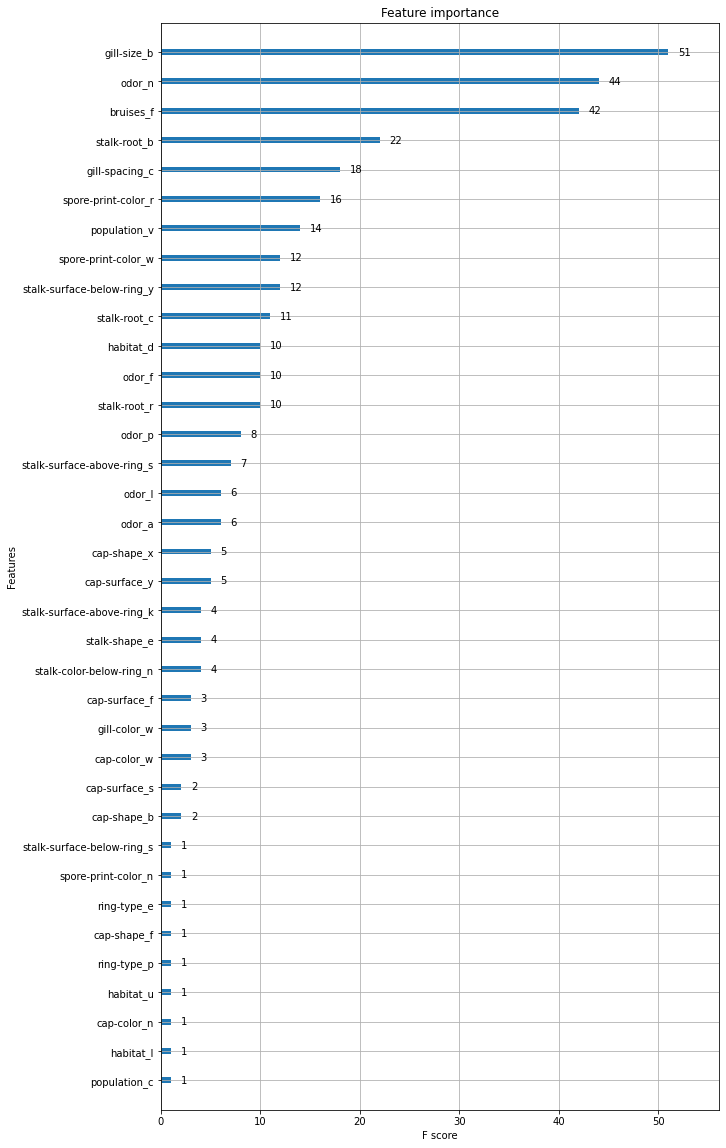

In [191]:
#Feature importance 
fig, ax = plt.subplots(figsize=(10, 20))
xgb.plot_importance(model, ax=ax)

In [192]:
for col in get_features(df_ohe_corr):
    print(f'Results for {col}')
    g = copy_df_with_nan_values(df_ohe_corr, set([col]))
    test_prediction(1000, g, model)
    print('\n')

Results for gill-spacing


ValueError: Feature shape mismatch, expected: 107, got 1